# Monte Carlo

This notebook presents the monte carlo process used in the paper. The actual code to run the monte carlo is monte_carlo.py and the code to reproduce figures 5 and 6 is in monte_carlo_analysis.ipynb.

---

In [ ]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from fitle import (
    Param, INPUT, fit, Cost,
    gaussian, exponential, crystalball, convolve, identity
)
import vector

## Setup

Import the required libraries with explicit imports from `fitle`.

The following is a nominal error distribution associated with LHCb data recorded in late July. We simulate data by applying a Gaussian resolution with a random value from the MERR distribution on a true mass value.

In [2]:
f = uproot.open("../data/MERR.root")

## Resolution Studies

Load the nominal mass error distribution (MERR) from LHCb data to use in the simulation.

In [3]:
Dp_DTF_MERR = f['DecayTree']["Dp_DTF_MERR"].array()

In [4]:
mu = 1970.
sigma = np.random.choice(Dp_DTF_MERR, 100000)
observed = np.multiply(sigma,np.random.randn(100000)) + mu

### Simulating Observed Mass

Generate mock observed data by smearing a true mass with a Gaussian resolution. The sigma values are drawn from the MERR distribution to simulate the event-by-event resolution.

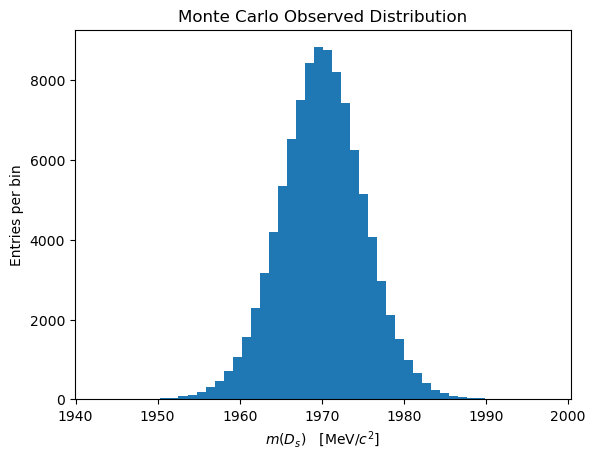

In [5]:
plt.hist(observed,bins=50)
plt.title('Monte Carlo Observed Distribution')
plt.ylabel('Entries per bin')
plt.xlabel('$m(D_s)$   [MeV/$c^2$]')
plt.show()

The next cells show fits of this observed distribution. It is not described well by a single-Gaussian resolution. Using a double-Gaussian radically improves the fit, and a triple-Gaussian's improvement is marginal. 

In [ ]:
cost = Cost.chi2(observed, 30, zero_method='absolute')
gauss = (+Param)(100000) * gaussian(mu=Param(1950), sigma=(+Param)(20))
fit_result = fit(gauss | cost, numba=False)
plt.errorbar(cost.x(), cost.y(), linestyle='', marker='.', color='black', yerr=np.sqrt(cost.y()))
plt.plot(cost.x(), gauss(cost.x()))
plt.yscale('log')
plt.text(1938, 4*10**3, f'$\chi^2$/ndf = {fit_result.minimizer.fval/(len(cost.x())-len(fit_result.values)-1):.02f}', fontsize=16)
plt.title('Single Gaussian Fit of Monte Carlo Observed Distribution')
plt.ylabel('Entries per bin')
plt.xlabel('$m(D_s)$   [MeV/$c^2$]')
plt.show()

### Resolution Model Comparison

We compare single, double, and triple Gaussian fits to understand how many Gaussian components are needed to describe the resolution.

In [ ]:
mu = Param(1950)
gauss2 = (+Param)(100000) * gaussian(mu=mu, sigma=(+Param)(20)) + (+Param)(100000) * gaussian(mu=mu, sigma=(+Param)(20))
fit_result = fit(gauss2 | cost, numba=False)
plt.errorbar(cost.x(), cost.y(), linestyle='', marker='.', color='black', yerr=np.sqrt(cost.y()))
plt.plot(cost.x(), gauss2(cost.x()))
plt.yscale('log')
plt.text(1938, 4*10**3, f'$\chi^2$/ndf = {fit_result.minimizer.fval/(len(cost.x())-len(fit_result.values)-1):.02f}', fontsize=16)
plt.title('Double Gaussian Fit of Monte Carlo Observed Distribution')
plt.ylabel('Entries per bin')
plt.xlabel('$m(D_s)$   [MeV/$c^2$]')
plt.show()

In [ ]:
mu = Param(1950)
gauss3 = (+Param)(100000) * gaussian(mu=mu, sigma=(+Param)(20)) + (+Param)(100000) * gaussian(mu=mu, sigma=(+Param)(20)) + (+Param)(100000) * gaussian(mu=mu, sigma=(+Param)(20))
fit_result = fit(gauss3 | cost, numba=False)
plt.errorbar(cost.x(), cost.y(), linestyle='', marker='.', color='black', yerr=np.sqrt(cost.y()))
plt.plot(cost.x(), gauss3(cost.x()))
plt.yscale('log')
plt.text(1938, 4*10**3, f'$\chi^2$/ndf = {fit_result.minimizer.fval/(len(cost.x())-len(fit_result.values)-1):.02f}', fontsize=16)
plt.title('Triple Gaussian Fit of Monte Carlo Observed Distribution')
plt.ylabel('Entries per bin')
plt.xlabel('$m(D_s)$   [MeV/$c^2$]')
plt.show()

## PHOTOS Data

PHOTOS is used to generate theoretical mass distributions accounting for photon radiation. A 500,000 entry subset of the 10,000,000 entry simulation is used here, and a pregenerated histogram of all data is used for fitting

In [9]:
Dp_tree=uproot.open("../data/mc/raw/Dp.root")["Truth"]["t"]

Dp_ssK_TRUEP_E = np.asarray(Dp_tree["ssK_TRUEP_E"])
Dp_ssK_TRUEP_X = np.asarray(Dp_tree["ssK_TRUEP_X"])
Dp_ssK_TRUEP_Y = np.asarray(Dp_tree["ssK_TRUEP_Y"])
Dp_ssK_TRUEP_Z = np.asarray(Dp_tree["ssK_TRUEP_Z"])

Dp_osK_TRUEP_E = np.asarray(Dp_tree["osK_TRUEP_E"])
Dp_osK_TRUEP_X = np.asarray(Dp_tree["osK_TRUEP_X"])
Dp_osK_TRUEP_Y = np.asarray(Dp_tree["osK_TRUEP_Y"])
Dp_osK_TRUEP_Z = np.asarray(Dp_tree["osK_TRUEP_Z"])

Dp_sspi_TRUEP_E = np.asarray(Dp_tree["sspi_TRUEP_E"])
Dp_sspi_TRUEP_X = np.asarray(Dp_tree["sspi_TRUEP_X"])
Dp_sspi_TRUEP_Y = np.asarray(Dp_tree["sspi_TRUEP_Y"])
Dp_sspi_TRUEP_Z = np.asarray(Dp_tree["sspi_TRUEP_Z"])

Dp_ssK_vec   = vector.array({"px": Dp_ssK_TRUEP_X, "py":Dp_ssK_TRUEP_Y, "pz":Dp_ssK_TRUEP_Z, "E":Dp_ssK_TRUEP_E})
Dp_osK_vec   = vector.array({"px": Dp_osK_TRUEP_X, "py":Dp_osK_TRUEP_Y, "pz":Dp_osK_TRUEP_Z, "E":Dp_osK_TRUEP_E})
Dp_sspi_vec  = vector.array({"px": Dp_sspi_TRUEP_X, "py":Dp_sspi_TRUEP_Y, "pz":Dp_sspi_TRUEP_Z, "E":Dp_sspi_TRUEP_E})

Dp_mother_vec = Dp_ssK_vec + Dp_osK_vec + Dp_sspi_vec
Dp_mother_mass = Dp_mother_vec.mass

### Loading PHOTOS Data

Load the $D^+$ and $D_s^+$ Monte Carlo samples generated with PHOTOS (for radiative tail modeling).

In [10]:
Ds_tree=uproot.open("../data/mc/raw/Ds.root")["Truth"]["t"]

Ds_ssK_TRUEP_E = np.asarray(Ds_tree["ssK_TRUEP_E"])
Ds_ssK_TRUEP_X = np.asarray(Ds_tree["ssK_TRUEP_X"])
Ds_ssK_TRUEP_Y = np.asarray(Ds_tree["ssK_TRUEP_Y"])
Ds_ssK_TRUEP_Z = np.asarray(Ds_tree["ssK_TRUEP_Z"])

Ds_osK_TRUEP_E = np.asarray(Ds_tree["osK_TRUEP_E"])
Ds_osK_TRUEP_X = np.asarray(Ds_tree["osK_TRUEP_X"])
Ds_osK_TRUEP_Y = np.asarray(Ds_tree["osK_TRUEP_Y"])
Ds_osK_TRUEP_Z = np.asarray(Ds_tree["osK_TRUEP_Z"])

Ds_sspi_TRUEP_E = np.asarray(Ds_tree["sspi_TRUEP_E"])
Ds_sspi_TRUEP_X = np.asarray(Ds_tree["sspi_TRUEP_X"])
Ds_sspi_TRUEP_Y = np.asarray(Ds_tree["sspi_TRUEP_Y"])
Ds_sspi_TRUEP_Z = np.asarray(Ds_tree["sspi_TRUEP_Z"])

Ds_ssK_vec   = vector.array({"px": Ds_ssK_TRUEP_X, "py":Ds_ssK_TRUEP_Y, "pz":Ds_ssK_TRUEP_Z, "E":Ds_ssK_TRUEP_E})
Ds_osK_vec   = vector.array({"px": Ds_osK_TRUEP_X, "py":Ds_osK_TRUEP_Y, "pz":Ds_osK_TRUEP_Z, "E":Ds_osK_TRUEP_E})
Ds_sspi_vec  = vector.array({"px": Ds_sspi_TRUEP_X, "py":Ds_sspi_TRUEP_Y, "pz":Ds_sspi_TRUEP_Z, "E":Ds_sspi_TRUEP_E})

Ds_mother_vec = Ds_ssK_vec + Ds_osK_vec + Ds_sspi_vec
Ds_mother_mass = Ds_mother_vec.mass

## Monte Carlo data for $D \rightarrow K K \pi$ decay channel

With this data, we can create a sampling function to generate data

In [11]:
def sample():
    raw_data_dp = np.random.choice(Dp_mother_mass, size=800000) + np.multiply(np.random.choice(Dp_DTF_MERR,800000),np.random.randn(800000)) 
    raw_data_ds = np.random.choice(Ds_mother_mass, size=1000000) + np.multiply(np.random.choice(Dp_DTF_MERR,1000000),np.random.randn(1000000))
    background = np.random.exponential(150, 60000)+1840
    return np.concatenate([raw_data_dp,raw_data_ds,background])

### Toy Monte Carlo Generation

Create a function to generate realistic mock data by combining:
- $D^+$ signal from PHOTOS with Gaussian smearing
- $D_s^+$ signal from PHOTOS with Gaussian smearing
- Exponential combinatorial background

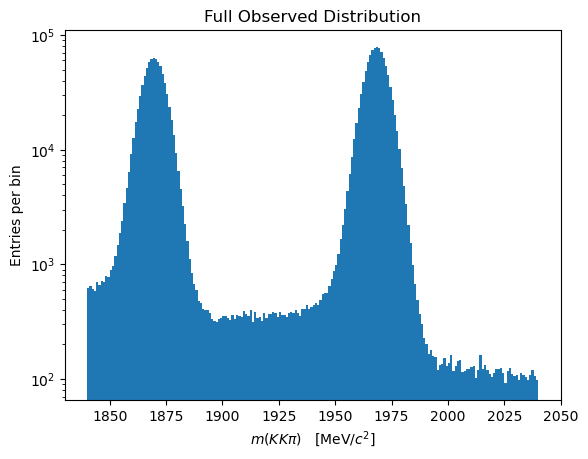

In [12]:
observed_full = sample()
plt.hist(observed_full,bins=200,range=(1840,2040))
plt.yscale('log')
plt.title('Full Observed Distribution')
plt.ylabel('Entries per bin')
plt.xlabel('$m(K K \pi)$   [MeV/$c^2$]')
plt.show()

## Crystal ball fit

Now we fit this distribution, using a Crystal ball and a Gaussian to model each peak

In [ ]:
# This function makes building models with interpretable N's easier
def model_sum(models, N=None, weights=None):
    if N is None:
        N = +Param
    elif np.isscalar(N):
        N = (+Param)(N)

    if weights is None:
        weights = [Param.unit('w') for _ in range(len(models) - 1)]

    weighted = [
        identity(weights[i] * models[i]) if i < len(models) - 1
        else identity(models[i] * (1 - sum(weights)))
        for i in range(len(models))
    ]

    return identity(N) * sum(weighted)

In [ ]:
crys1_mass2 = Param('mass')(1970)
crys1_mass1 = crys1_mass2 - Param('mass_diff')(100)

crys1_alpha1 = Param('alpha1')(3.6)(0.5, 5)
crys1_n1_raw = Param('n_raw')(0.05)  # unconstrained
crys1_n1 = 1.0 + crys1_n1_raw**2     # ensures n >= 1

crys1_alpha2 = Param('alpha2')(1.8)(0.5, 5)
crys1_n2_raw = Param('n_raw')(0.05)  # unconstrained
crys1_n2 = 1.0 + crys1_n1_raw**2     # ensures n >= 1

s1 = (+Param('s1'))(5)
s2 = (+Param('s2'))(5)
s3 = (+Param('s3'))(5)
s4 = (+Param('s4'))(5)

crys1_Dp = model_sum(
    [
        crystalball(crys1_alpha1, crys1_n1, crys1_mass1, s1), 
        gaussian(crys1_mass1, s2)
    ], 1e6
)

crys1_Ds = model_sum(
    [
        crystalball(crys1_alpha2, crys1_n2, crys1_mass2, s3),
        gaussian(crys1_mass2, s4)
    ], 1e6
)

crys1_tail = (+Param)(40000) * exponential(tau=(+Param)(300), start=1840, end=2040)
crys1 = crys1_Dp + crys1_Ds + crys1_tail

In [ ]:
crys1_fit = fit(crys1 | Cost.chi2(observed_full, 200, range=(1840, 2040)), numba=False, grad=False)
crys1_fit

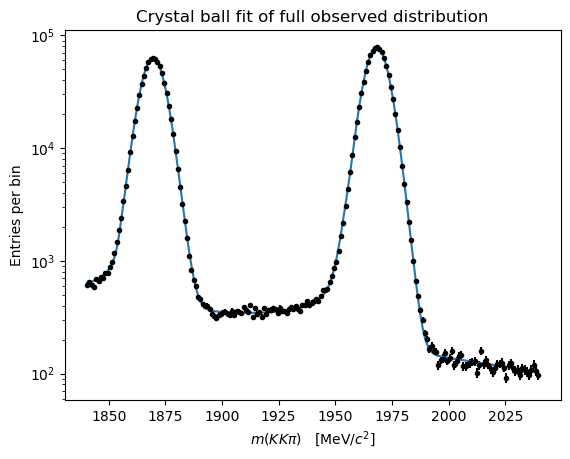

In [20]:
crys1_fit.plot_data()
crys1_fit.plot_fit()
plt.title('Crystal ball fit of full observed distribution')
plt.yscale('log')
plt.ylabel('Entries per bin')
plt.xlabel('$m(K K \pi)$   [MeV/$c^2$]')
plt.show()

## Convolution fit

Now we fit it with the convolutional method. Recall that the double Gaussian resolution is a good descriptor of nominal errors. Because of that, we fit each peak with two convolutions at the same mu

In [21]:
Dp_x, Dp_c = np.load("../data/mc/histograms/Dp.npy")
Ds_x, Ds_c = np.load("../data/mc/histograms/Ds.npy")

Dp_mother_mass = 1869.65
Ds_mother_mass = 1968.33

### Loading MC Templates for Fitting

Load the pre-binned histograms for the convolution fit.

In [ ]:
# Bin width for 200 bins over [1840, 2040]
bin_width = (2040 - 1840) / 200  # = 1.0

conv1_mass2 = Param('mass')(1970)
conv1_mass1 = conv1_mass2 - Param('mass_diff')(100)

sigma1 = (+Param)(5)
sigma2 = (+Param)(10)
sigma3 = (+Param)(5)
sigma4 = (+Param)(10)

conv1_Dp = (+Param)(500000) * convolve(Dp_x, Dp_c, Dp_mother_mass, conv1_mass1, sigma1, bin_width=bin_width) + \
           (+Param)(500000) * convolve(Dp_x, Dp_c, Dp_mother_mass, conv1_mass1, sigma2, bin_width=bin_width)
conv1_Ds = (+Param)(600000) * convolve(Ds_x, Ds_c, Ds_mother_mass, conv1_mass2, sigma3, bin_width=bin_width) + \
           (+Param)(600000) * convolve(Ds_x, Ds_c, Ds_mother_mass, conv1_mass2, sigma4, bin_width=bin_width)
conv1_tail = (+Param)(40000) * exponential(tau=(+Param)(100), start=1840, end=2040)
conv1 = conv1_Dp + conv1_Ds + conv1_tail

### Convolution Model

Build a model using the MC templates convolved with Gaussian resolution. Each peak uses a double Gaussian resolution (sum of two different widths).

In [ ]:
conv1_fit = fit(conv1 | Cost.chi2(observed_full, 200, range=(1840, 2040)))
conv1_fit

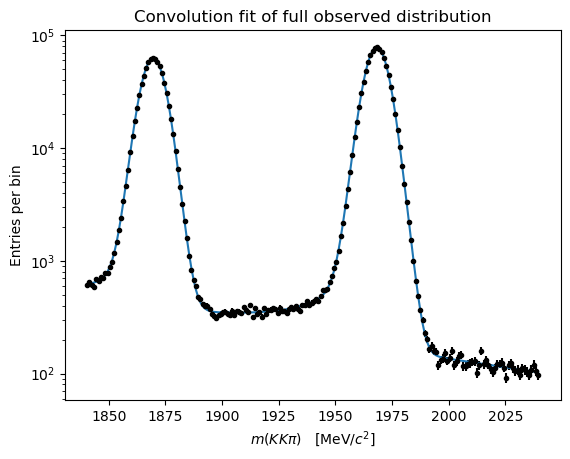

In [24]:
conv1_fit.plot_data()
conv1_fit.plot_fit()
plt.title('Convolution fit of full observed distribution')
plt.yscale('log')
plt.ylabel('Entries per bin')
plt.xlabel('$m(K K \pi)$   [MeV/$c^2$]')
plt.show()

In [26]:
prints = [
    ['Model', 'chi^2/ndf', 'mu1 (MeV)', 'Error', 'mu_diff (MeV)','Error'], 
    ['Truth', 'n/a', 1968.33, 0, 98.68, 0],
    ['Crystal ball', f"{crys1_fit.minimizer.fval/crys1_fit.dof():.2f}", f"{crys1_fit.values['mass']:.2f}", f"{crys1_fit.errors['mass']:.4f}",f"{crys1_fit.values['mass_diff']:.2f}",f"{crys1_fit.errors['mass_diff']:.4f}"],
    ['Conv', f"{conv1_fit.minimizer.fval/conv1_fit.dof():.2f}", f"{conv1_fit.values['mass']:.2f}", f"{conv1_fit.errors['mass']:.4f}",f"{conv1_fit.values['mass_diff']:.2f}",f"{conv1_fit.errors['mass_diff']:.4f}"]
]

[print("{0: <16}{1: <12}{2: <10}{3: <12}{4: <10}{5: <12}".format(*p)) for p in prints][0]

Model           chi^2/ndf   mu1 (MeV) Error       mu_diff (MeV)Error       
Truth           n/a         1968.33   0           98.68     0           
Crystal ball    2.19        1968.27   0.0055      98.71     0.0082      
Conv            1.15        1968.33   0.0053      98.68     0.0080      


## Method Comparison

Compare the Crystal Ball and Convolution fitting methods. Key metrics:
- **$\chi^2$/ndf**: Fit quality (lower is better)
- **$\mu$**: Extracted $D_s^+$ mass (should match true value of 1968.33 MeV)
- **$\Delta\mu$**: Mass difference $m(D_s^+) - m(D^+)$ (should match 98.68 MeV)